In [1]:
#@title
 ###EP2MAC0417/MAC5768
 ##################################################################
 # AOPREENCHERESSECABEÇALHOCOMOMEUNOMEEOMEUNÚMEROUSP,#
 # DECLAROQUESOUOÚNICOAUTORERESPONSÁVELPELARESOLUÇÃO #
 # DESTEEP. #
 # TODASASPARTESFORAMDESENVOLVIDASEIMPLEMENTADASPORMIM, #
 # SEGUINDOASINSTRUÇÕESEQUEPORTANTO,NÃOCONSTITUEM #
 # DESONESTIDADEACADÊMICAOUPLÁGIO. #
 # #
 # DECLAROTAMBÉM,QUESOURESPONSÁVELPORTODASASCÓPIAS #
 # DESSEPROGRAMA,EQUEEUNÃODISTRIBUIOUFACILITEIA #
 # SUADISTRIBUIÇÃO.ESTOUCIENTEQUEOSCASOSDEPLÁGIOE #
 # DESONESTIDADEACADÊMICASERÃOTRATADOSSEGUNDOOSCRITÉRIOS #
 # DEFINIDOSNOCÓDIGODEÉTICADAUSP. #
 # #
 # ENTENDOQUEJUPYTERNOTEBOOKSSEMASSINATURANÃOSERÃO #
 # CORRIGIDOSE,AINDAASSIM,PODERÃOSERPUNIDOSPOR #
 # DESONESTIDADEACADÊMICA. #
 # #
 # #
 # Nome: João Pedro C. Feitosa
 # NUSP: 10741569
 # Turma: MAC0417
 # Prof.: Ronando Hashimoto
 #################################################################

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
metadados = pd.read_csv("metadados.csv")

### Funções

In [4]:
def mostrar_imagem(img, bw = True):
    plt.figure(figsize = (8,8))
    if bw == True:
        plt.imshow(img, cmap = "gray", vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.axis("off")

In [5]:
def equalizacao(img):
    if img.ndim > 2:
        img = img[:,:,0]
    
    histograma, bins = np.histogram(img.flatten(), bins=256, range=[0,256])
    cdf = histograma.cumsum()
    cdf_normalizado = 255 * cdf / cdf[-1]
    imagem_equalizada = np.interp(img.flatten(), bins[:-1], cdf_normalizado)
    
    return imagem_equalizada.reshape(img.shape).astype("int")

***Exemplo***

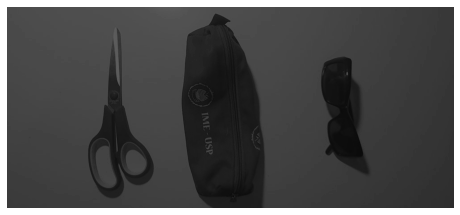

In [6]:
caminho_exemplo = "dados/augmentedDataset/exponencial/001.jpg"

with open(caminho_exemplo, 'rb') as f:
    exemplo = plt.imread(f)
    mostrar_imagem(exemplo)

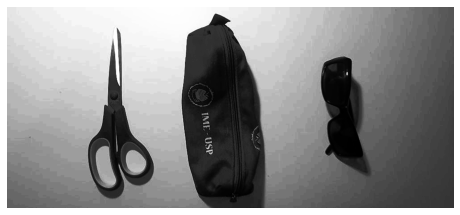

In [7]:
exemplo_equalizado = equalizacao(exemplo)
mostrar_imagem(exemplo_equalizado)

### Criação de Sub-diretórios

Criaremos 5 subdiretórios dentro do diretório ***normalizedDataset***:
 - *constrast_stretching*
 - *log*
 - *exponencial*
 - *laplaciano*
 - *media*

In [8]:
for subdiretorio in ["constrast_stretching", "log", "exponencial", "laplaciano", "media"]:
    caminho = f"dados/normalizedDataset/{subdiretorio}"
    if not os.path.exists(caminho):
        os.makedirs(caminho)

In [9]:
for n in range(1,145):
    for subdiretorio in ["constrast_stretching", "log", "exponencial", "laplaciano", "media"]:
        caminho = f"dados/augmentedDataset/{subdiretorio}/{n:03d}.jpg"
        novo_caminho = f"dados/normalizedDataset/{subdiretorio}/{n:03d}.jpg"
        if not os.path.exists(novo_caminho):
            with open(caminho, 'rb') as f:
                imagem = plt.imread(f)
            
            imagem_equalizada = equalizacao(imagem)
            plt.imsave(novo_caminho, imagem_equalizada, cmap = "gray", format = "jpg")

### Visualização de Histogramas

In [10]:
# cria um arquivo com os dados para os histogramas

if not os.path.exists("intensidades_histogramas.csv"):
    # cria um dicionário com arrays vazios
    
    intensidades = {}

    for luz in (1,2,3,4):
        for diretorio in ["augmented", "normalized"]:
            for subdiretorio in ["constrast_stretching", "log", "exponencial", "laplaciano", "media"]: 
                intensidades[f"{diretorio}_{subdiretorio}_{luz}"] = np.array([])

        intensidades[f"originalGray_{luz}"] = np.array([])    
    
    # preenche os arrays para cada um dos dataset/tipos de iluminação
    
    for n in range(1,145):
        luz = metadados["luz"][n - 1]

        for diretorio in ["originalGrayDataset", "augmentedDataset", "normalizedDataset"]:
            pos_D = diretorio.find("D")

            for subdiretorio in ["constrast_stretching", "log", "exponencial", "laplaciano", "media"]:

                if diretorio == "originalGrayDataset":
                    caminho = f"dados/{diretorio}/{n:03d}.jpg"
                else:
                    caminho = f"dados/{diretorio}/{subdiretorio}/{n:03d}.jpg"

                with open(caminho, 'rb') as f:
                    imagem = plt.imread(f)
                if imagem.ndim > 2:
                    imagem = imagem[:,:,0]
                ints = imagem.flatten()

                if diretorio == "originalGrayDataset":
                    chave = f"{diretorio[:pos_D]}_{luz}"
                else:
                    chave = f"{diretorio[:pos_D]}_{subdiretorio}_{luz}"

                intensidades[chave] = np.append(intensidades[chave], ints)


                if diretorio == "originalGrayDataset":
                    break
                    
    # salva os dados em um dataframe e salva ele como csv           
                    
    intensidades_df = pd.DataFrame(intensidades)
    incidencia_intensidades = intensidades_df.apply(pd.Series.value_counts).fillna(0).astype(int)
    incidencia_intensidades = incidencia_intensidades.reindex(range(256), fill_value=0)
    incidencia_intensidades.to_csv("intensidades_histogramas.csv", index = False)

In [11]:
df_intensidades = pd.read_csv("intensidades_histogramas.csv")

In [47]:
def visualiza_histograma(data, diretorio, luz, cor = "black"):
    series_gray = data[f"originalGray_{luz}"]
    series_aug = data[f"augmented_{diretorio}_{luz}"]
    series_norm = data[f"normalized_{diretorio}_{luz}"]
    
    # histogramas

    plt.figure(figsize = (20,10))
    plt.subplot(2,3,1)
    plt.title(f'originalGrayDataset - Luz {luz}')
    plt.ylabel('Incidência Total')
    plt.xlabel('Intensidade')
    plt.bar(series_gray.index, series_gray.values, width=1.0, edgecolor = cor)
    plt.subplot(2,3,2)
    plt.title(f'augmentedDataset/{diretorio} - luz {luz}')
    plt.xlabel('Intensidade')
    plt.bar(series_aug.index, series_aug.values, width=1.0, edgecolor = cor)
    plt.subplot(2,3,3)
    plt.title(f'normalizedDataset/{diretorio} - luz {luz}')
    plt.xlabel('Intensidade')
    plt.bar(series_norm.index, series_norm.values, width=1.0, edgecolor = cor)
    
    # imagens
    
    n_aleatorio = metadados[metadados["luz"] == luz].sample(n = 1).index[0] + 1
    
    for i, c in enumerate(["originalGrayDataset", f"augmentedDataset/{diretorio}", f"normalizedDataset/{diretorio}"]):
        caminho = f"dados/{c}/{n_aleatorio:03d}.jpg"
        with open(caminho, 'rb') as f:
            imagem = plt.imread(f)
        
        plt.subplot(2,3,i+4)
        plt.imshow(imagem, cmap = "gray", vmin=0, vmax=255)
            
    plt.suptitle(f"Histogramas: {diretorio} - Luz {luz}", fontsize = 20)
    plt.show()

***Contrast Stretching***

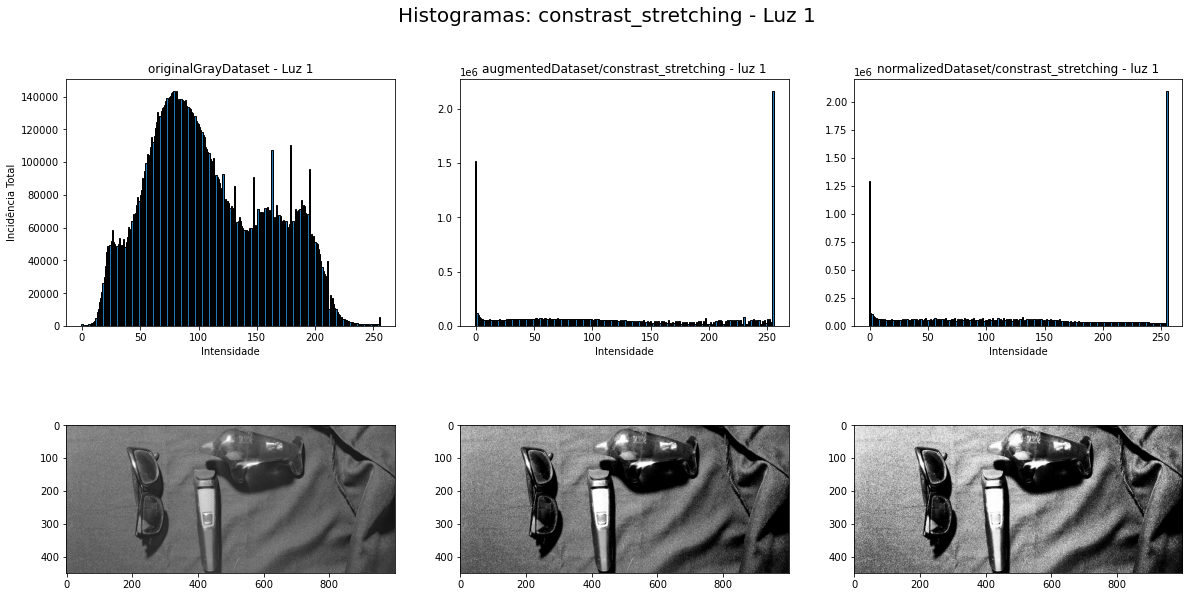

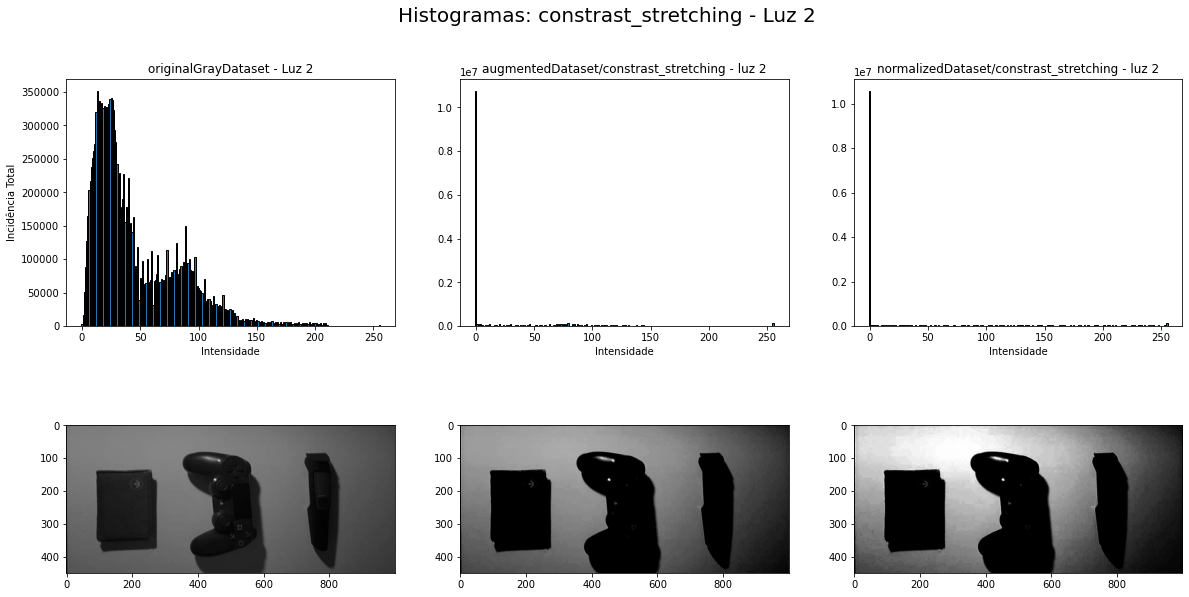

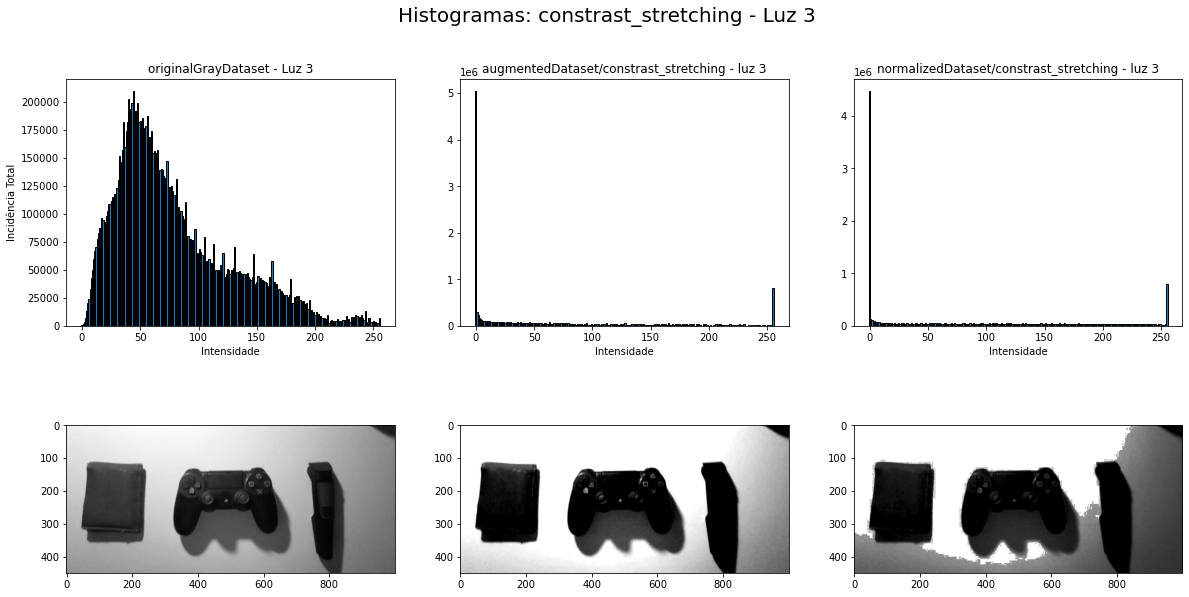

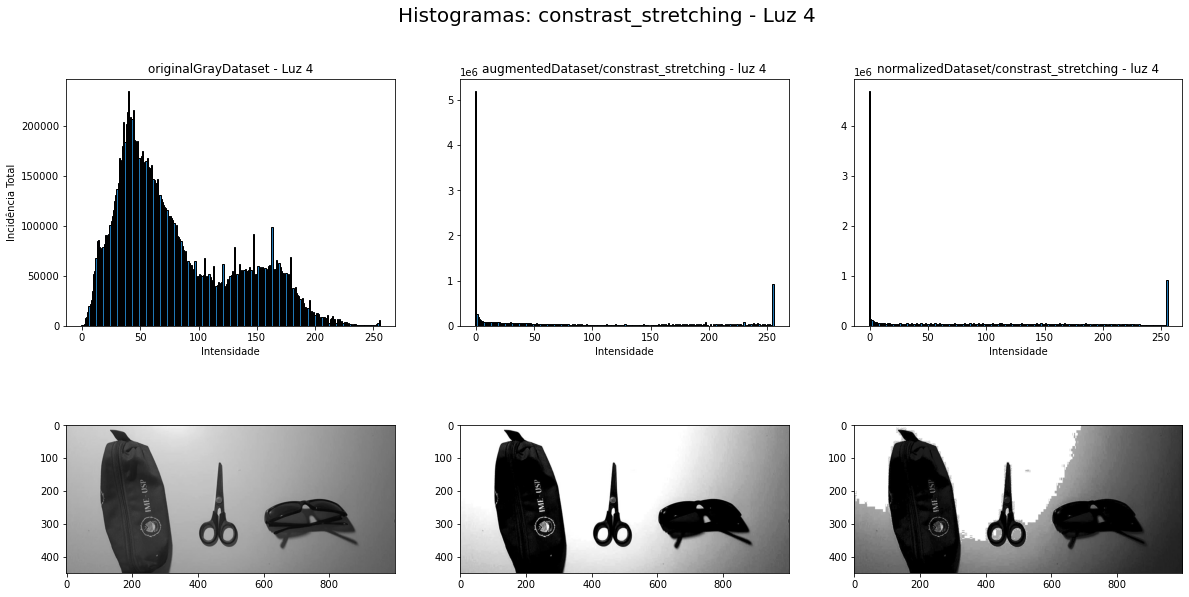

In [48]:
for i in range(1,5):
    visualiza_histograma(df_intensidades, "constrast_stretching", i)

Podemos observar que, em geral, a equalização de histograma não funciona de maneira ideal para as imagens às quais se aplicou Contrast Stretching. Em todas as iluminações, as intensidades ficam super concentradas em 0 e 255, o que atrapalha o funcionamento da equalização de histogramas. Nas imagens observadas, a equalização não melhorou necessariamente a nitidez da imagem, o que se obervou, na verdade, foi uma iluminação "estourada".

***Log***

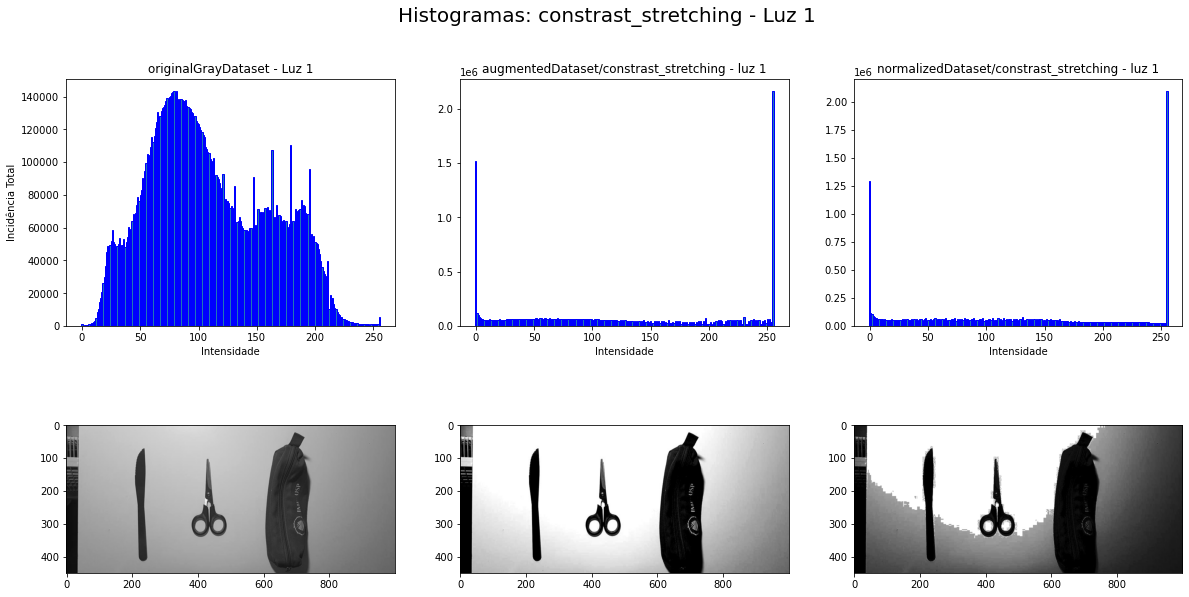

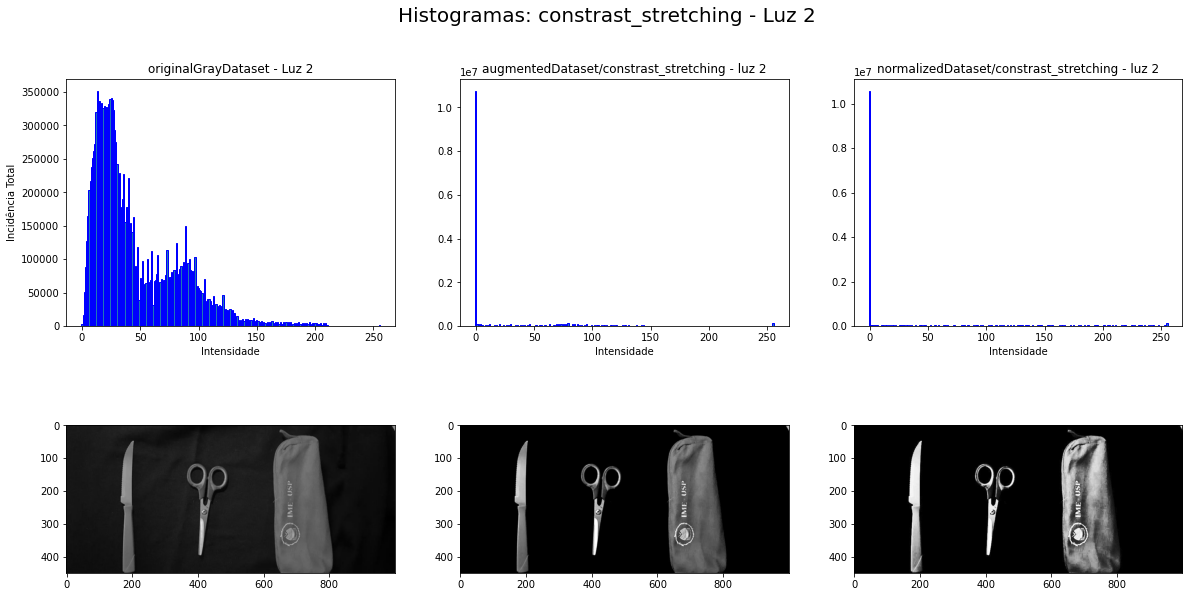

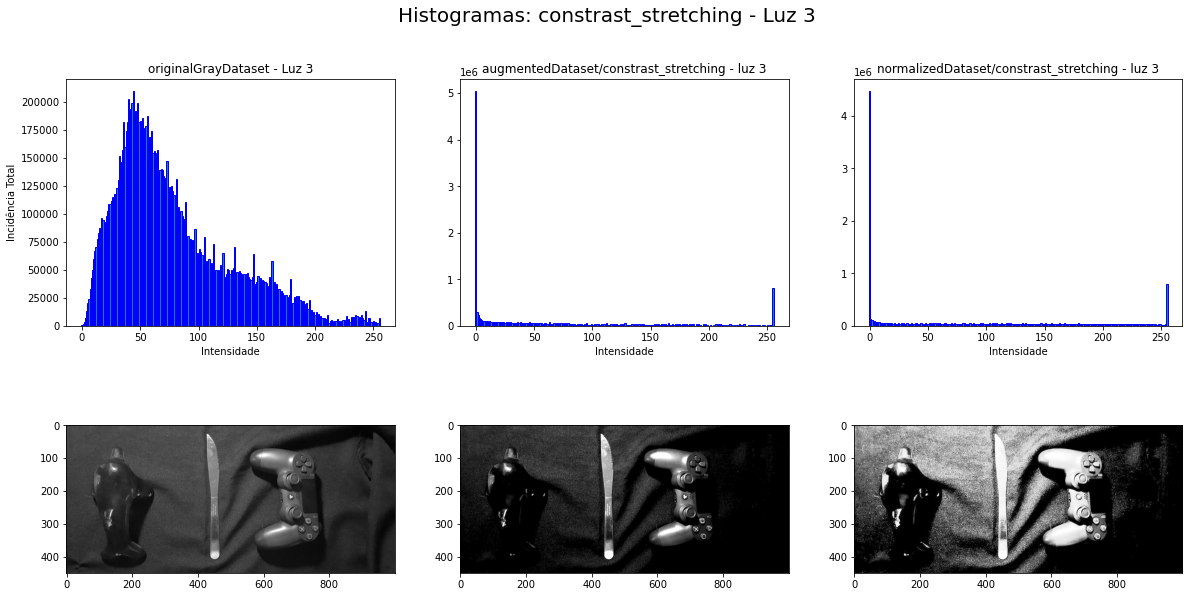

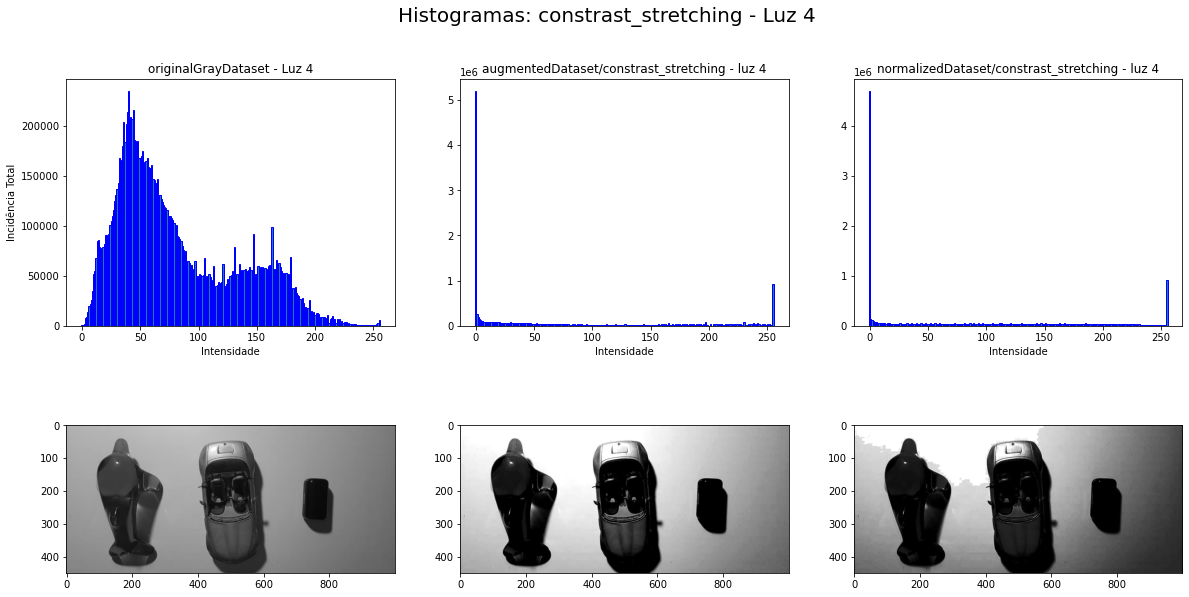

In [49]:
for i in range(1,5):
    visualiza_histograma(df_intensidades, "constrast_stretching", i, "blue")

O que foi dito para o Contrast Stretching também se aplica à transformação Log.

***Exponencial***

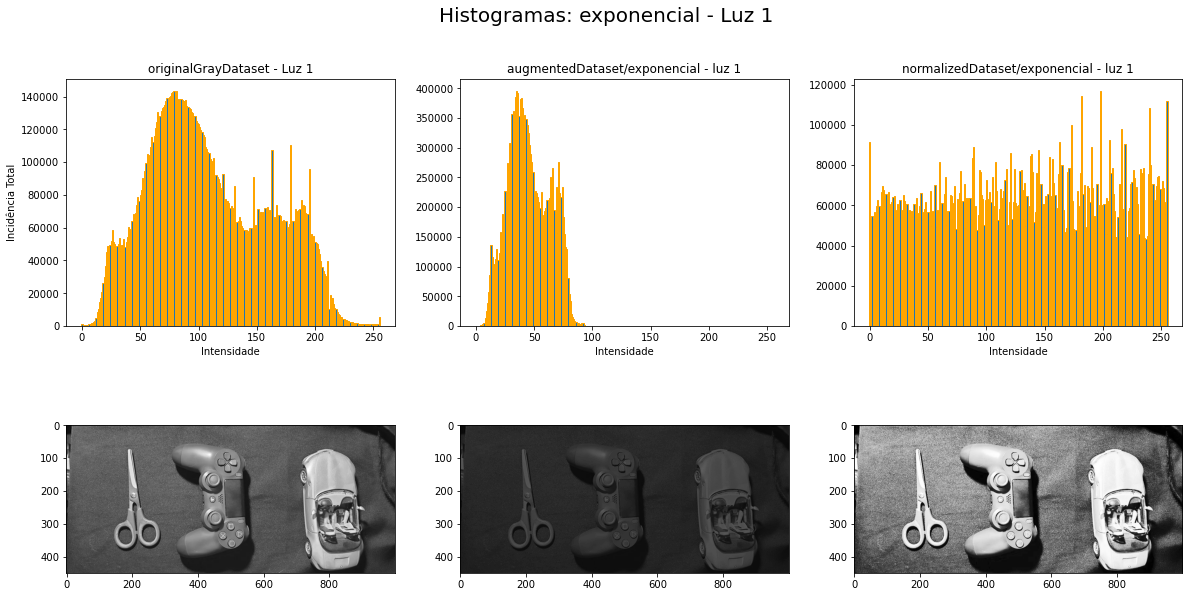

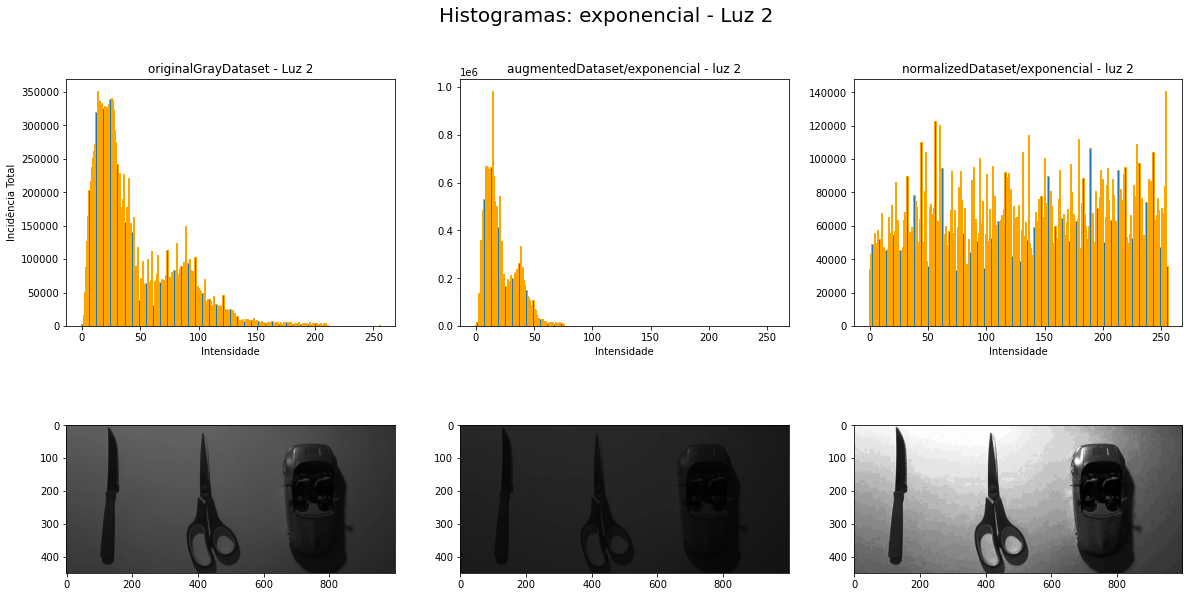

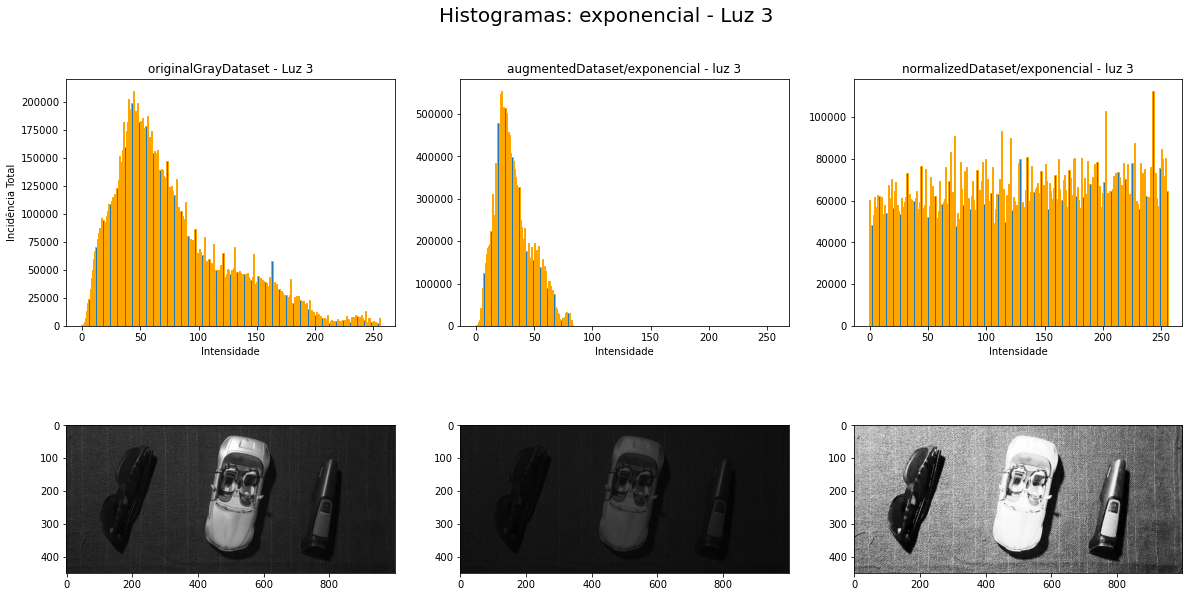

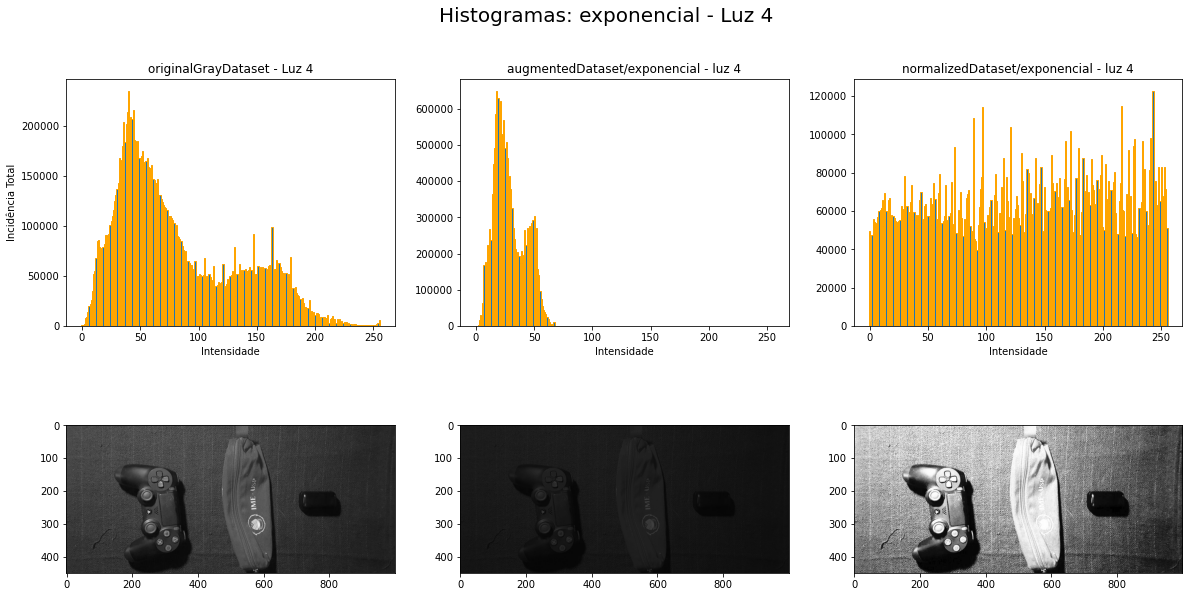

In [50]:
for i in range(1,5):
    visualiza_histograma(df_intensidades, "exponencial", i, "orange")

No caso da transformação gamma, podemos ver que a equalização de histogramas funcionou da forma adequada. Podemos observar nos exemplos um aumento claro de nitidez dos objetos, o que indica que a transformação foi bem aplicada.

***Laplaciano***

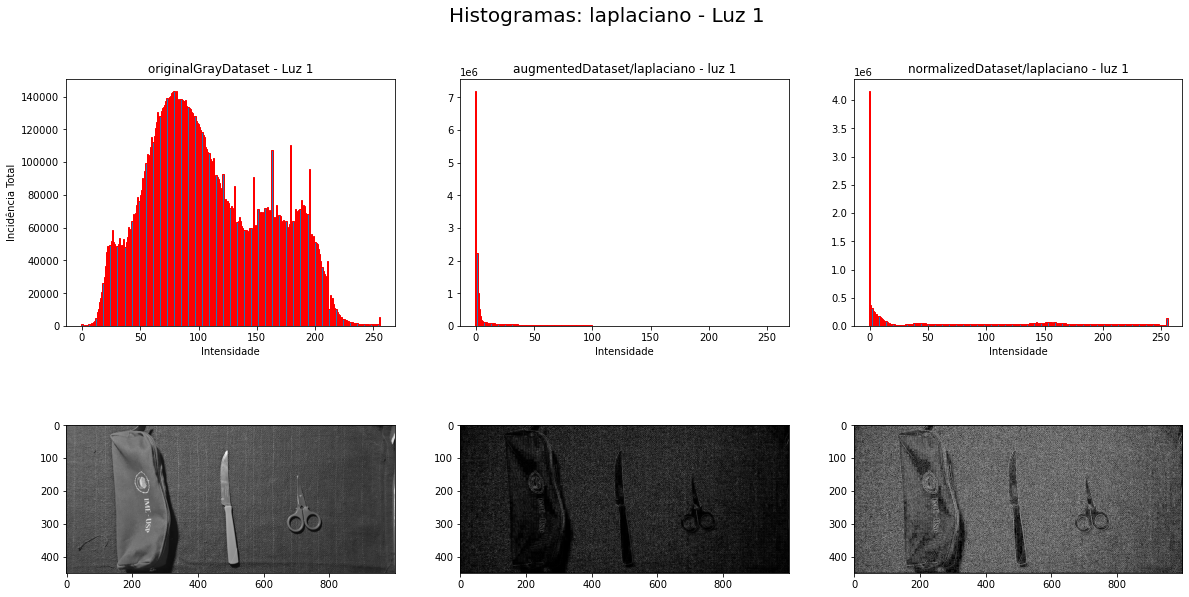

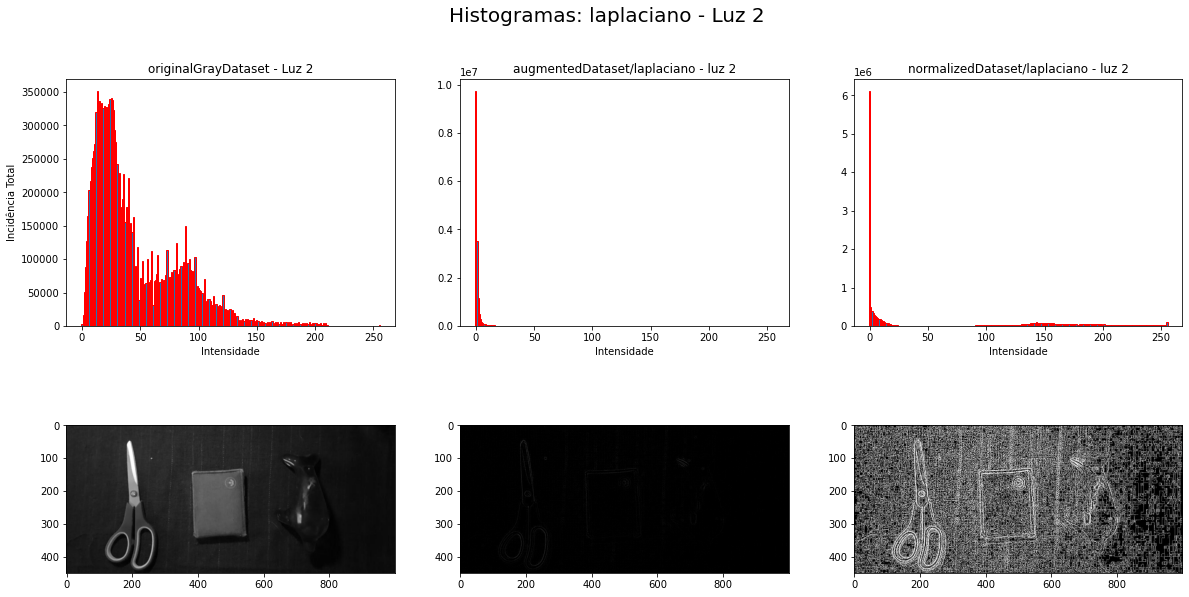

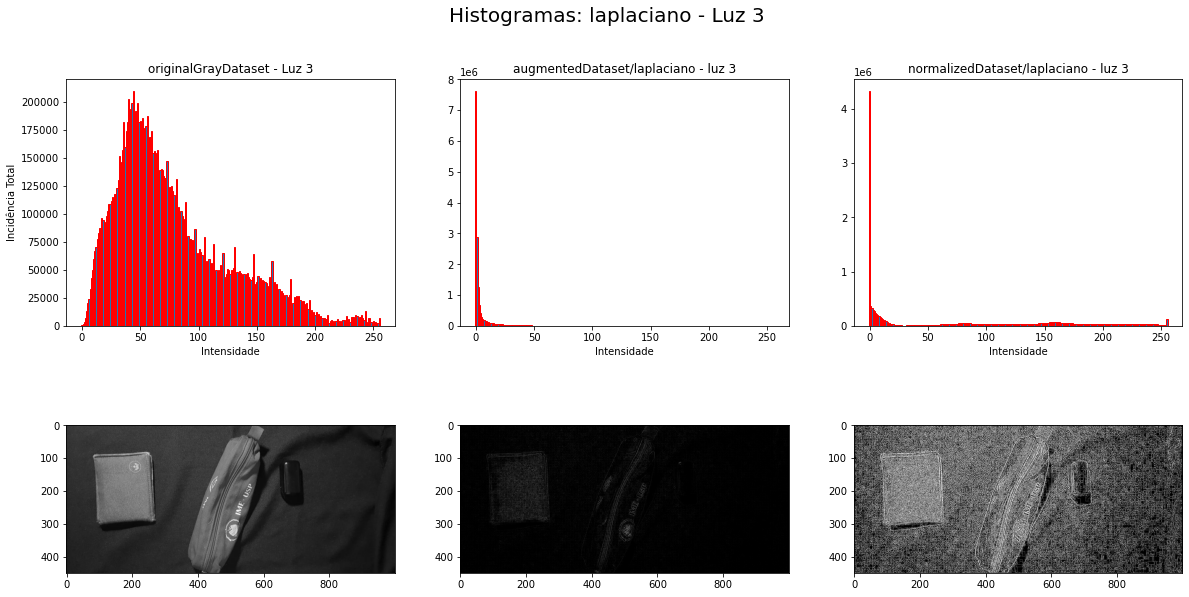

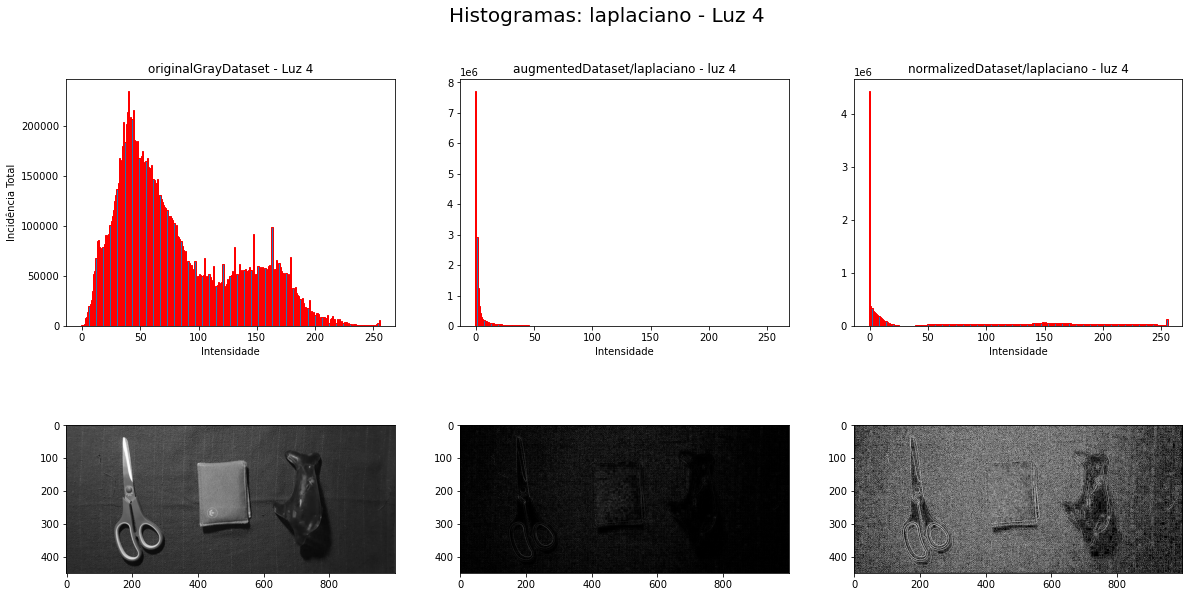

In [51]:
for i in range(1,5):
    visualiza_histograma(df_intensidades, "laplaciano", i, "red")

No caso do laplaciano, podemos observar o problema de concentração de valores de intensidade baixa (próxima a 0). A equalização de histogramas ajuda a balancear a distribuição, como podemos observar nos histogramas plotadas. Além disso, a transformação aumenta a nitidez dos objetos da imagem. Embora haja uma grande quantidade de ruído, ele não foi introduzidos pela equalização, mas sim em etapas prévias.

***Média***

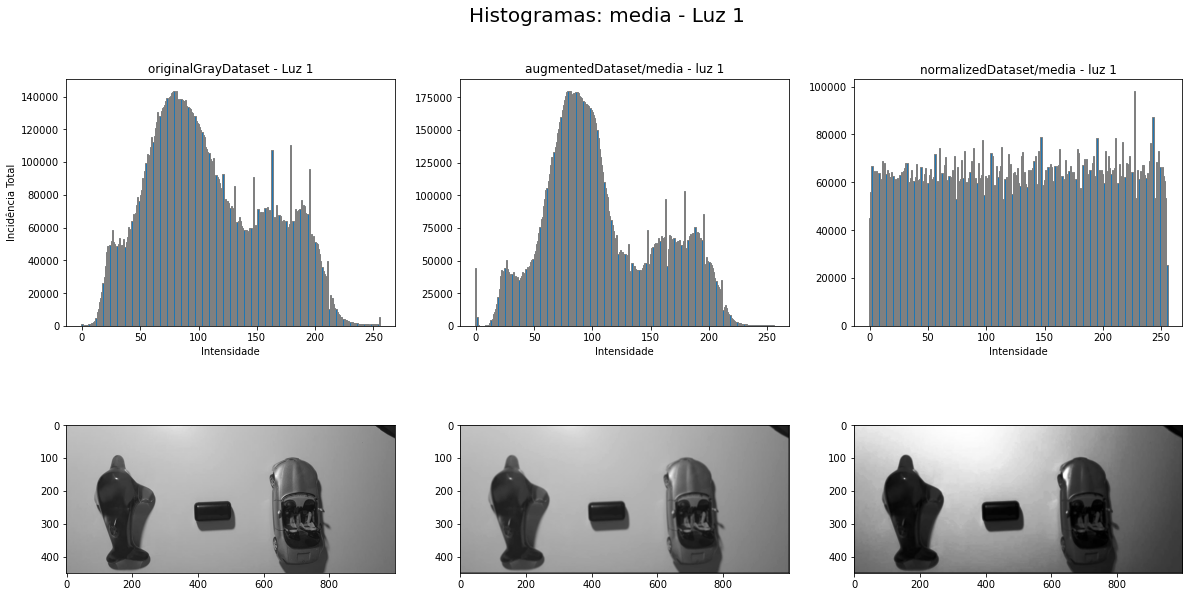

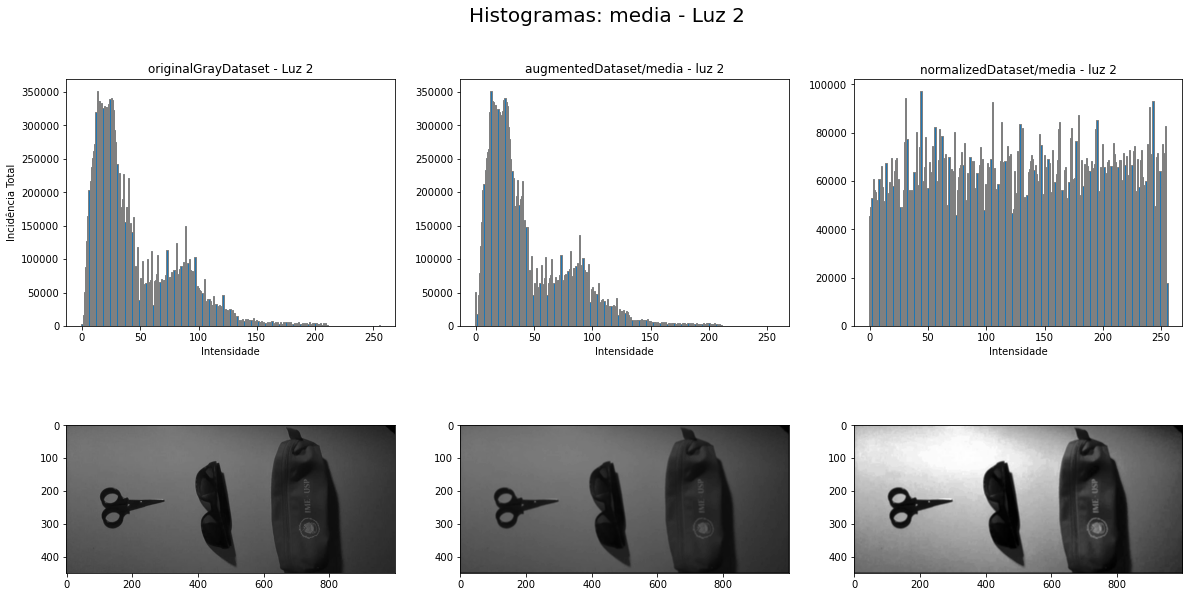

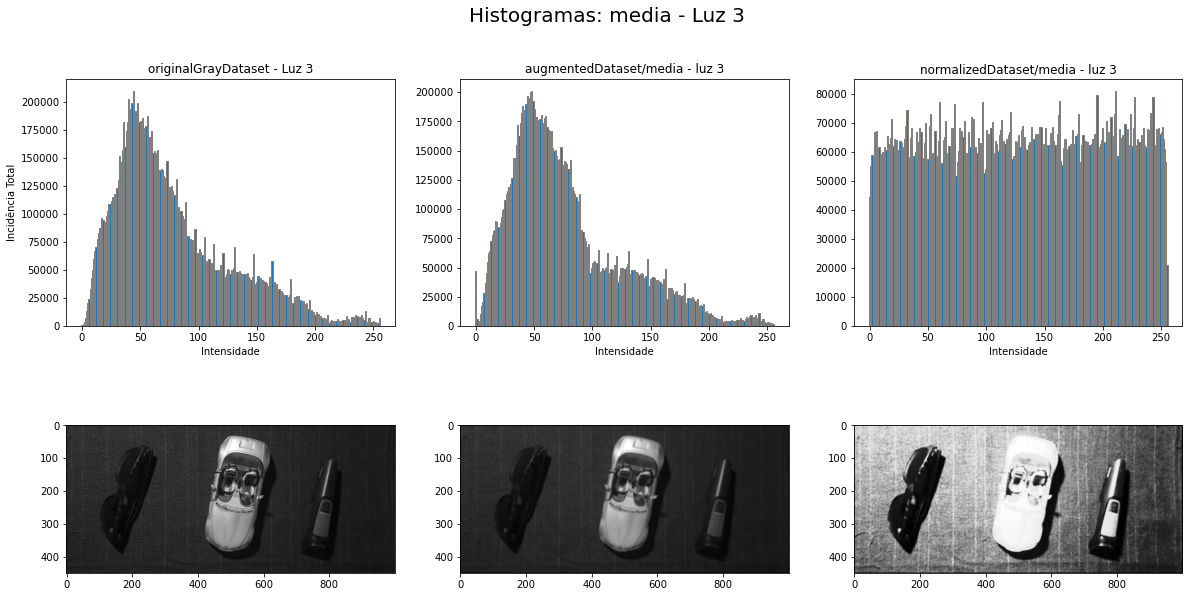

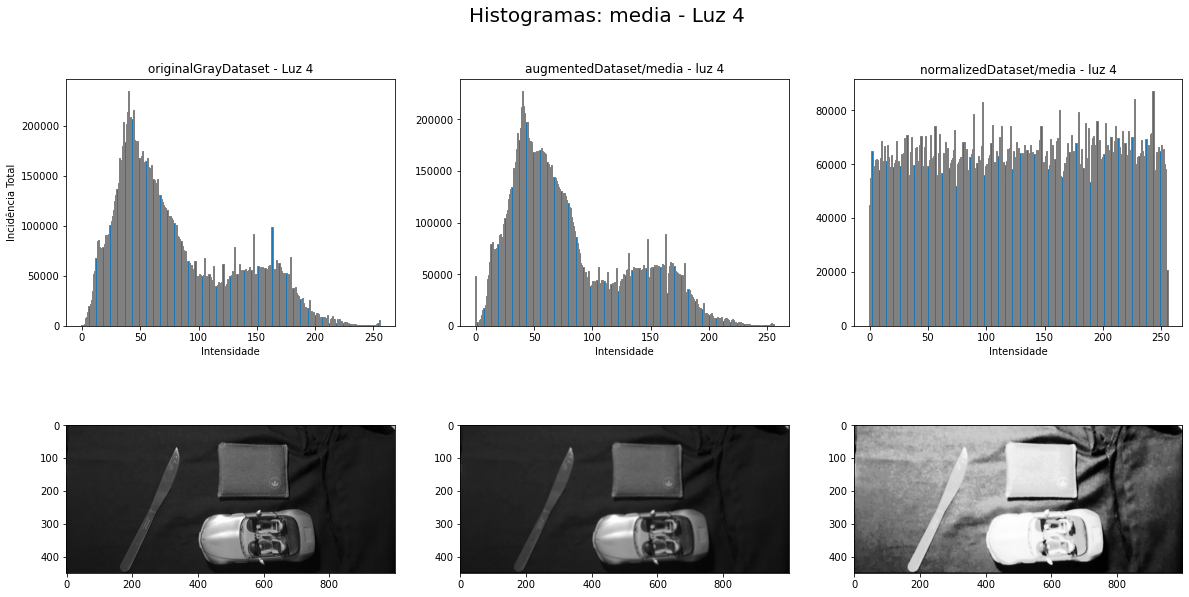

In [52]:
for i in range(1,5):
    visualiza_histograma(df_intensidades, "media", i, "gray")

Em relação às imagens criadas por smoothing, não podemos ver uma melhoria clara da qualidade das imagens finais ao se aplicar a equalização de histogramas. É evidente que a equalização é executada, observando-se os histogramas plotados, entretanto não parecia haver a necessidade de equalização nesse caso. As imagens ficaram, em geral, mais claras, mas isso não aumentou sua visibilidade.